# Experiment 1: VUS vs FF-VUS vs FF-VUS-GPU vs AUC at slope 0

## Setup

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

In [43]:
project_root_path = os.path.join('..', '..')
experiment_path = os.path.join(project_root_path, 'experiments', 'vus_ffvus_auc_0_tsb')
results_path = os.path.join(experiment_path, 'results')

save_fig_path = os.path.join(experiment_path, 'figures')
os.makedirs(save_fig_path, exist_ok=True)

In [44]:
def load_results(csv_file):
    return pd.read_csv(csv_file, index_col=0)

result_files = [file for file in os.listdir(results_path) if file.endswith('.csv')]
print(f'Number of result files: {len(result_files)}')

Number of result files: 4


In [45]:
# Initialize an empty DataFrame to store the combined data
df = pd.DataFrame()

# Read and combine all files
for file in tqdm(result_files):
    file_path = os.path.join(results_path, file)
    curr_df = pd.read_csv(file_path, index_col=0)
    df = pd.concat([df, curr_df], ignore_index=True)

df.sample(3)

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 130.17it/s]


,Time series,Length,Number of anomalies,Anomalies average length,Slope size,Step,Global mask,Slopes,Existence,Confusion matrix,...,Position time,Slopes time,Existence time,Confusion matrix time,Precision recall curve time,Integral time,Metric,Metric value,Metric time,Anomalies coordinates time
6222,OPPORTUNITY/S2-ADL3.test.csv@91.out,33983,2,456.500000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,AUC-PR,0.036560,0.003101,NaN
6560,SMD/machine-3-10.test.csv@14.out,23692,13,80.538462,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,AUC-PR,0.094070,0.002476,NaN
344,OPPORTUNITY/S2-ADL3.test.csv@38.out,33983,2,456.500000,0.0,1.0,True,precomputed,NaN,dynamic_plus,...,0.000049,0.000007,2.384186e-07,0.000151,0.000013,0.000012,FF-VUS-PR,0.026866,0.001515,NaN


In [46]:
color_palette = {
    'FF-VUS-PR': 'lightgreen',
    'FF-VUS-PR-GPU': 'lightblue',
    'AUC-PR': 'lightcoral',
    'VUS-PR': 'orange',
}

## Analysis

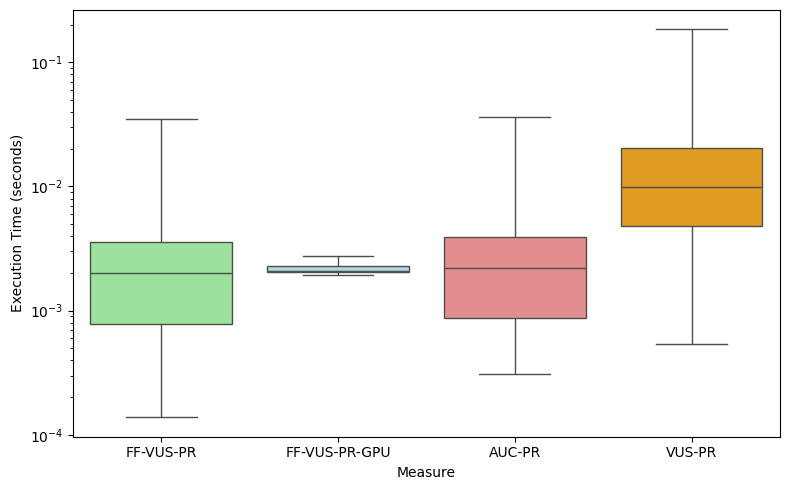

In [47]:
# TODO: Remove -PR
# TODO: Add (L: 0, E: False)

# What is the execution time difference
median_times = df.groupby('Metric')['Metric time'].median()
order = median_times.sort_values().index.to_list()

plt.figure(figsize=(8, 5))
sns.boxplot(y='Metric time', x='Metric', hue='Metric', data=df, showfliers=False, log_scale=True, palette=color_palette, order=order)
plt.xlabel('Measure')
plt.ylabel('Execution Time (seconds)')
plt.tight_layout()
plt.savefig(os.path.join(save_fig_path, 'exec_time_comparison.svg'))
plt.show()

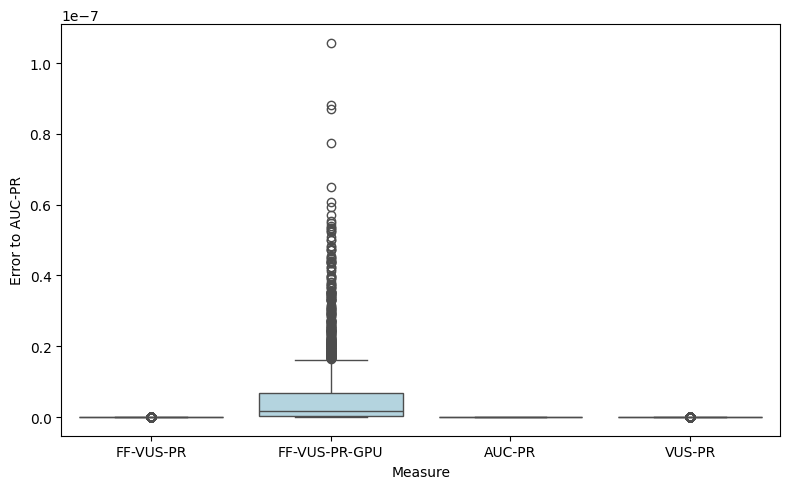

In [48]:
# TODO: We will show this in the next subsection, where we compare FFVUS, VUS for every slope

# What is the error between the difference metrics
plt.figure(figsize=(8, 5))
metrics = df['Metric'].unique()

values_df = df[['Time series', 'Metric', 'Metric value']]
values_df = values_df.pivot(columns='Metric', index='Time series', values='Metric value')
dif_df = values_df.copy()
for metric in metrics: 
    dif_df[metric] = values_df[metric] - values_df['AUC-PR']
dif_df

sns.boxplot(dif_df.abs(), showfliers=True, palette=color_palette, order=order)
plt.xlabel('Measure')
plt.ylabel('Error to AUC-PR')
plt.tight_layout()
plt.savefig(os.path.join(save_fig_path, 'error_to_aucpr.svg'))
plt.show()

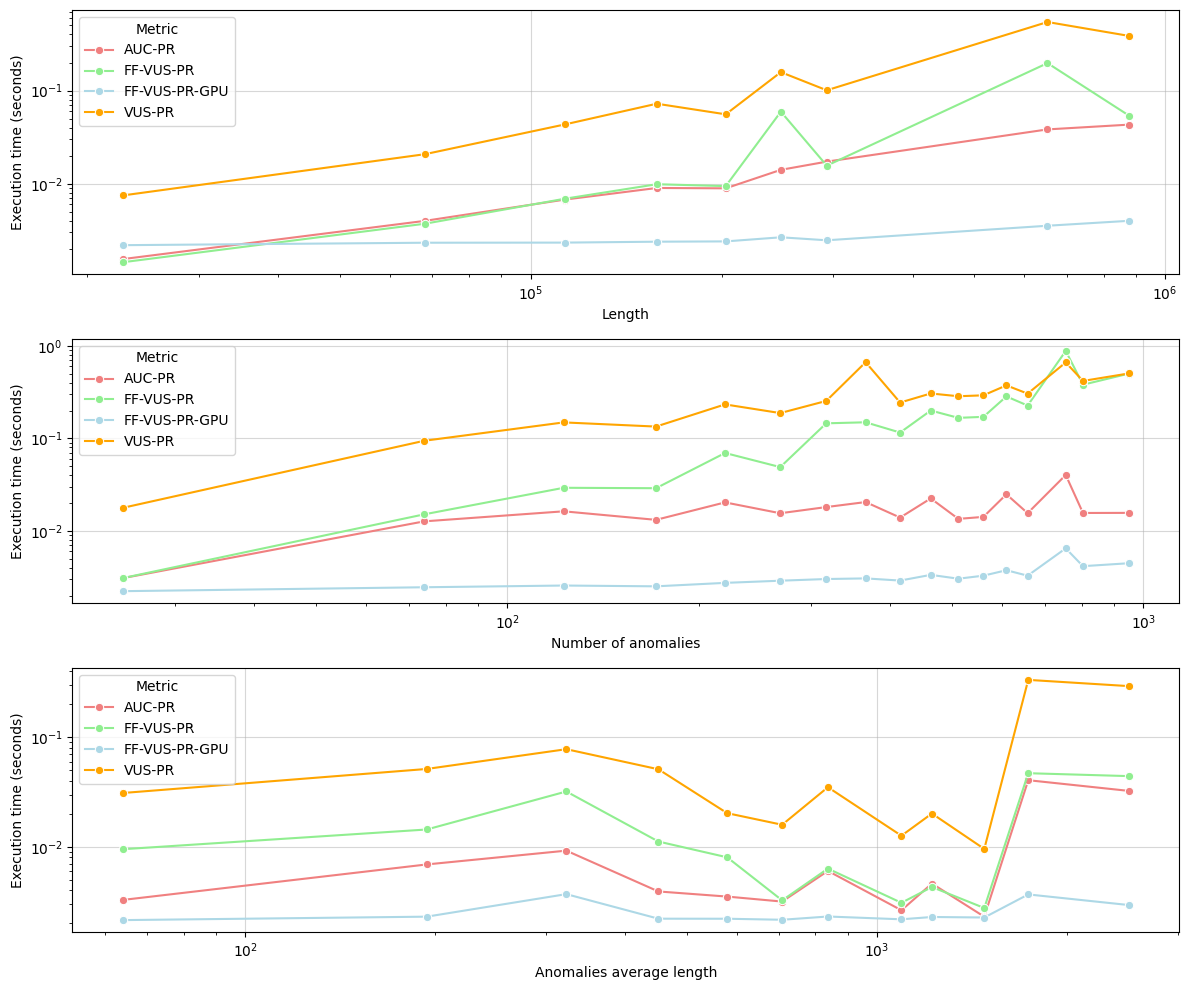

In [50]:
fig, ax = plt.subplots(3, 1, figsize=(12, 10))
attributes = ["Length", "Number of anomalies", "Anomalies average length"]
bins = 20  # adjust based on data spread
curr_df = df.copy()

for attribute, axis in zip(attributes, ax):
    # Bin the attribute
    # curr_df[f'{attribute}_bin'] = pd.qcut(curr_df[attribute], q=bins, duplicates='drop')
    curr_df[f'{attribute}_bin'] = pd.cut(curr_df[attribute], bins=bins)
    
    # Group by bin and metric, compute mean
    grouped = (
        curr_df
        .groupby([f'{attribute}_bin', 'Metric'], observed=False)['Metric time']
        .mean()
        .reset_index()
    )

    # Convert bin to the midpoint for plotting
    grouped['bin_center'] = grouped[f'{attribute}_bin'].apply(lambda x: x.mid)

    # Plot
    sns.lineplot(
        x='bin_center',
        y='Metric time',
        hue='Metric',
        data=grouped,
        ax=axis,
        palette=color_palette,
        marker='o'
    )

    # axis.set_title(f"Metric Time vs {attribute}")
    axis.set_xlabel(attribute)
    axis.set_ylabel("Execution time (seconds)")
    axis.set_yscale('log')
    axis.set_xscale('log')
    axis.grid(axis='both', alpha=0.5)

plt.tight_layout()
plt.savefig(os.path.join(save_fig_path, 'exec_time_per_attr.svg'))
plt.show()